In [1]:
import itertools
import joblib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------
SAVE_SCORE = True
SAVE_MODEL = True
SAVE_PLOT = True

In [2]:
# jupyter notebook settings

dark_orange = "#FF8C00"
dark_blue = "#00008B"
dark_green = "#006400"
dark_cyan = "#008B8B"
dark_slate = "#2F4F4F"
dark_magenta = "#8B008B"
dark_red = "#8B0000"
dark_olive = "#556B2F"
crimson = "#DC143C"

yellow_green = "#9ACD32"
lime_green = "#32CD32"
lime = "#00FF00"
gold = "#FFD700"
golden_rod = "#DAA520"
dark_golden_rod = "#B8860B"
light_blue = "#AED6F1"
light_red = "#F1948A"
highlight_green = "green"
highlight_red = "red"

color_train = dark_cyan
color_test = "#1f77b4"
color_future = "#ff7f0e"
color_forecast = "#ff7f0e"
color_predict = yellow_green


In [3]:
# funções auxiliares

def tes_optimizer(train, test, abg, trend="add", seas="add", step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    
    for i, comb in enumerate(abg, start=1):
        tes_model = ExponentialSmoothing(
            train, 
            trend=trend, 
            seasonal=seas, 
            seasonal_periods=24).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        
        # y_pred = tes_model.forecast(step)
        y_pred = tes_model.forecast(len(test))
        y_true = test["production"]

        if np.isnan(y_pred).any() or np.isinf(y_pred).any():
            continue
        
        mae = mean_absolute_error(y_true, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

# ---------------------------------------------------------------------------------------------------------------------
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()

    if y_true.shape != y_pred.shape:
        raise ValueError(f"y_true e y_pred devem ter o mesmo tamanho: {y_true.shape} != {y_pred.shape}")

    mask = y_true != 0
    # return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))


# sMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    # return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


# MASE
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    mae_model = mean_absolute_error(y_true, y_pred)

    try:
        hour_median_train = y_train.groupby(y_train.index.hour).median()
        mapped_values = y_true.index.hour.map(hour_median_train)
        mae_naive = mean_absolute_error(y_true, mapped_values)

        return 0 if mae_naive == 0 else mae_model / mae_naive

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def calculate_forecast_accuracy(y_true, y_pred, y_train):
    y_true_day = y_true.between_time('06:00:00', '18:00:00')
    y_pred_day = y_pred.between_time('06:00:00', '18:00:00')
    y_train_day = y_train.between_time('06:00:00', '18:00:00')

    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": mean_squared_error(y_true, y_pred, squared=False),
        "mse": mean_squared_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mase": mean_absolute_scaled_error(y_true, y_pred, y_train),
        "mae_day": mean_absolute_error(y_true_day, y_pred_day),
        "rmse_day": mean_squared_error(y_true_day, y_pred_day, squared=False),
        "mse_day": mean_squared_error(y_true_day, y_pred_day),
        "r2_day": r2_score(y_true_day, y_pred_day),
        "mape_day": mean_absolute_percentage_error(y_true_day, y_pred_day),
        "mase_day": mean_absolute_scaled_error(y_true_day, y_pred_day, y_train_day),
    }


def print_forecast_accuracy(y_true, y_pred, y_train, title):
    acc = calculate_forecast_accuracy(y_true, y_pred, y_train)

    print(f"Resumo das métricas de precisão (forecast accuracy - {title})".center(120))
    print("-" * 120)

    print(f"{'Métrica |':<10} {'24h':<6}| {'(dia)':<7}| {'Descrição':<50}")
    print("-" * 120)
    print(f"MAE     | ({acc['mae']:>5.2f} - {acc['mae_day']:>5.2f}) | As previsões, em média, estão ({acc['mae']:0.2f} - {acc['mae_day']:0.2f}) unidades distantes dos valores reais.")
    print(f"RMSE    | ({acc['rmse']:>5.2f} - {acc['rmse_day']:>5.2f}) | O erro médio do seu modelo é de ({acc['rmse']:0.2f} - {acc['rmse_day']:0.2f}) unidades em relação aos valores observados.")
    print(f"R²      | ({acc['r2']:>5.2f} - {acc['r2_day']:>5.2f}) | O coeficiente de determinação R² é ({acc['r2']*100:0.2f}% - {acc['r2']*100:0.2f}%).")
    print(f"MSE     | ({acc['mse']:>5.2f} - {acc['mse_day']:>5.2f}) | A média dos quadrados das diferenças entre os valores previstos e reais é ({acc['mse']:0.2f} - {acc['mse']:0.2f})")
    print(f"MAPE    | ({acc['mape']:>5.2f} - {acc['mape_day']:>5.2f}) | As previsões, em média, estão desviando em ({acc['mape']*100:0.2f}% - {acc['mape']*100:0.2f}%) dos valores reais.")
    print(f"MASE    | ({acc['mase']:>5.2f} - {acc['mase_day']:>5.2f}) | O erro médio do seu modelo é {acc['mase']:0.2f} vezes maior que o erro médio do modelo Naive Lag.")
    print("-" * 120)

# ----------------------------------------------------------------------------------------------------------------------------

def plot_forecast(df, name, start=None, end=None, span=False):
    if SAVE_PLOT:
        span = False

    df_plot = df[start:end] if start and end else df.copy()
    plt.figure(figsize=(22, 5))

    for col in df.columns:
        params = {
            "train": {"label": "Train set", "color": color_train, "lw": 2, "ls": "-"},
            "test": {"label": "Test set", "color": color_test, "lw": 2, "ls": "-"},
            "y_pred": {"label": "Predict", "color": color_forecast, "lw": 2, "ls": "-"},
        }.get(col, {"label": None, "color": None, "lw": None})

        if 'pred' in col:
            params.update({'lw': 3, 'ls': '--'})

        if all(params.values()):
            plt.plot(
                df_plot.index, 
                df_plot[col], 
                label=params["label"], 
                color=params["color"], 
                lw=params["lw"], 
                ls=params["ls"]
            )
        
        if span:
            df_span = df_plot[df_plot["test"].notnull()]["test"]
            plt.axvspan(df_span.index.min(), df_span.index.max(), color=light_blue, alpha=0.09)
    
    if not SAVE_PLOT:
        plt.title(f"LDTEA - {name} Predict Test set", fontsize=16, fontweight="bold", pad=20)

    plt.ylabel("KWh", fontsize=16, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y", alpha=0.5, linewidth=1.2)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.legend(
        loc="upper left",
        fontsize=16,
        frameon=True,
        shadow=True,
        framealpha=1,
        facecolor="white",
        bbox_to_anchor=(1, 1),
    )
    plt.tight_layout()
    if SAVE_PLOT:
        plt.savefig(f"../figures/tes/{name}.pdf", dpi=300)
        plt.savefig(f"../figures/tes/{name}.svg", dpi=300)
    plt.show()


def save_model(model, model_type):
    notebook_dir = Path.cwd()
    model_path = notebook_dir.parent / "models"
    
    if not model_path.exists():
        model_path.mkdir()
    
    file_path = model_path / f"{model_type}_model.joblib"
    joblib.dump(model, file_path)
    print(f"Modelo {model_type} salvo em {model_path}")


def save_score_metrics(metrics, name, metadata=None):
    metrics_path = Path.cwd().parent / "data" / "results" / "estatical_models"
    metrics_path.mkdir(parents=True, exist_ok=True)
    file_path = metrics_path / f"{name}.csv"

    df = pd.DataFrame([metrics]) if not isinstance(metrics, pd.DataFrame) else metrics.copy()
    df = df.assign(model=name, features=df.index, dataset=metadata.get("dataset", ""))

    columns_order = ["model", "features", "dataset"] + [col for col in df.columns if col not in ["model", "features", "dataset"]]
    df = df[columns_order]

    if metadata:
        df = df.assign(**metadata)

    try:
        mode = "a" if file_path.exists() else "w"
        header = not file_path.exists()
        df.to_csv(file_path, mode=mode, header=header, index=False)
        print(f"Métricas salvas com sucesso em: {file_path}")
    except Exception as e:
        print(f"Erro ao salvar as métricas: {e}")




In [4]:
# Constants:

FREQUENCY = "H"
DATE_COL = "date_time"
TARGET = "ldtea_avg"

START_DATE = "2023-06-01 00:00:00"
SPLIT_TEST_DATE = "2024-03-19 23:59:59"
SPLIT_DATE_EVAL = "2024-05-31 23:59:59"
END_DATE = "2024-06-30 23:59:59"

In [5]:
# Carregar dados de produção de energia (freq 1H).

file_path = "../data/final/1.1_energy_prod_ldtea.csv"
cols = [DATE_COL, TARGET]

df_raw = pd.read_csv(file_path, usecols=cols, parse_dates=[DATE_COL],  index_col=DATE_COL)
df_raw.sort_index(inplace=True)
df_raw = df_raw.asfreq(FREQUENCY)

print(f"index - {df_raw.index.min()} {df_raw.index.max()}")
print(f"freq : {df_raw.index.freq} - shape: {df_raw.shape}")
df_raw


index - 2023-06-01 00:00:00-03:00 2024-06-30 23:00:00-03:00
freq : <Hour> - shape: (9504, 1)


ldtea_avg
date_time                           
2023-06-01 00:00:00-03:00       0.00
2023-06-01 01:00:00-03:00       0.00
2023-06-01 02:00:00-03:00       0.00
2023-06-01 03:00:00-03:00       0.00
2023-06-01 04:00:00-03:00       0.00
...                              ...
2024-06-30 19:00:00-03:00       4.08
2024-06-30 20:00:00-03:00       4.08
2024-06-30 21:00:00-03:00       4.08
2024-06-30 22:00:00-03:00       4.08
2024-06-30 23:00:00-03:00       4.08

[9504 rows x 1 columns]

In [6]:
# Dividir os dados em treino, teste e validação

df_base = df_raw.loc[START_DATE:SPLIT_DATE_EVAL].copy()
df_train = df_raw.loc[START_DATE:SPLIT_TEST_DATE].copy()
df_test = df_raw.loc[SPLIT_TEST_DATE:SPLIT_DATE_EVAL].copy()
df_eval = df_raw.loc[SPLIT_DATE_EVAL:END_DATE].copy()

datasets = [
    ('df_raw', df_raw),
    ('df_base', df_base),
    ('df_train', df_train),
    ('df_test', df_test),
    ('df_eval', df_eval)
]

for name, df in datasets:
    shape = f"({df.shape[0]}, {df.shape[1]})"
    date_range = f"{df.index.min()} - {df.index.max()}"
    print(f"{name:<12} {shape:<14} {date_range:<23}")

total_rows = df_raw.shape[0]
train_rows = df_train.shape[0]
test_rows = df_test.shape[0]
eval_rows = df_eval.shape[0]

print(f"\nProportion of train data: {train_rows / total_rows:.2%}")
print(f"Proportion of test data: {test_rows / total_rows:.2%}")
print(f"Proportion of evaluation data: {eval_rows / total_rows:.2%}")

df_raw       (9504, 1)      2023-06-01 00:00:00-03:00 - 2024-06-30 23:00:00-03:00
df_base      (8784, 1)      2023-06-01 00:00:00-03:00 - 2024-05-31 23:00:00-03:00
df_train     (7032, 1)      2023-06-01 00:00:00-03:00 - 2024-03-19 23:00:00-03:00
df_test      (1752, 1)      2024-03-20 00:00:00-03:00 - 2024-05-31 23:00:00-03:00
df_eval      (720, 1)       2024-06-01 00:00:00-03:00 - 2024-06-30 23:00:00-03:00

Proportion of train data: 73.99%
Proportion of test data: 18.43%
Proportion of evaluation data: 7.58%


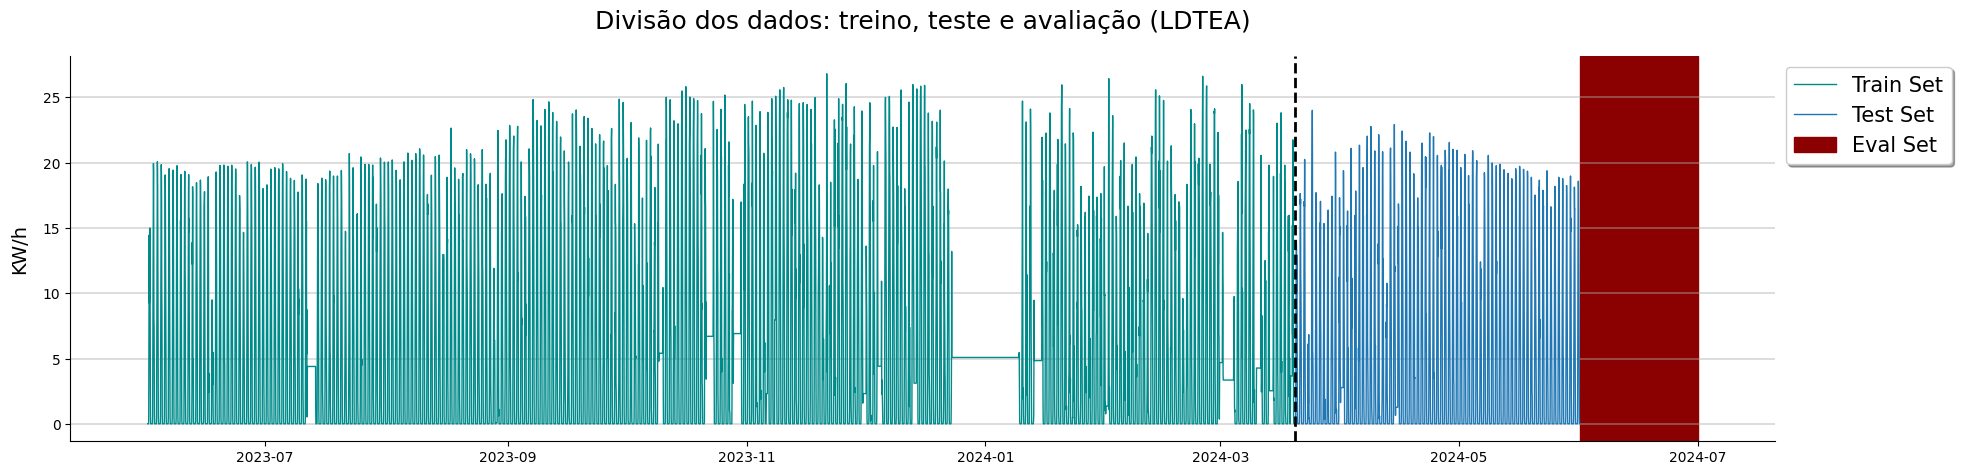

In [7]:
plt.figure(figsize=(22, 5))
plt.plot(df_train.index, df_train[TARGET], lw=1, color=color_train, label="Train Set")
plt.plot(df_test.index, df_test[TARGET], lw=1, color=color_test, label="Test Set")
plt.plot(df_eval.index, df_eval[TARGET], lw=0)

plt.xlabel("")
plt.ylabel("KW/h", fontsize=14, labelpad=10)
plt.title("Divisão dos dados: treino, teste e avaliação (LDTEA)", fontsize=18, pad=20)

plt.axvline(df_train.index.max(), color="black", lw=2, linestyle="--")
plt.axvspan(SPLIT_DATE_EVAL, df_raw.index.max(), alpha=1, color=dark_red, label="Eval Set")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)

plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.show()

In [8]:
small_value = 1e-1  # 0.1
df_train["production_pos"] = df_train.replace(0, small_value)
df_train.head()


ldtea_avg  production_pos
date_time                                           
2023-06-01 00:00:00-03:00        0.0             0.1
2023-06-01 01:00:00-03:00        0.0             0.1
2023-06-01 02:00:00-03:00        0.0             0.1
2023-06-01 03:00:00-03:00        0.0             0.1
2023-06-01 04:00:00-03:00        0.0             0.1

In [9]:
# Melhores parâmetros para o modelo TES utilizando ..

# alphas = betas = gammas = np.arange(0.10, 1, 0.20)
# abg = list(itertools.product(alphas, betas, gammas))

# best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(df_train, df_test, abg)
# print(f"best_alpha: {best_alpha}, best_beta: {best_beta}, best_gamma: {best_gamma}, best_mae: {best_mae}")

# ---------------------------------------------------------------------------------------------------------------------------

best_alpha_add = 0.5
best_beta_add = 0.9
best_gamma_add = 0.1

best_alpha_mul = 0.1 
best_beta_mul = 0.1
best_gamma_mul = 0.1


In [10]:
# Fit the Holt-Winters model

start_time_model = time.time()

model_add = ExponentialSmoothing(
    df_train[TARGET], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=24
)

model_mul = ExponentialSmoothing(
    df_train['production_pos'], 
    trend='mul', 
    seasonal='mul', 
    seasonal_periods=24
)

model_add_fit = model_add.fit()
model_mul_fit = model_mul.fit()

model_add_sss_fit = model_add.fit(
    smoothing_level=best_alpha_add, 
    smoothing_slope=best_beta_add, 
    smoothing_seasonal=best_gamma_add
)

model_mul_sss_fit = model_mul.fit(
    smoothing_level=best_alpha_mul, 
    smoothing_slope=best_beta_mul, 
    smoothing_seasonal=best_gamma_mul
)

elapsed_time_train_set = (time.time() - start_time_model) / 2
print(f"Tempo de treinamento: {elapsed_time_train_set:.2f} segundos")


Tempo de treinamento: 5.41 segundos


In [11]:
df_pred = df_test.rename(columns={TARGET: "y_true"}).copy()

y_pred = model_add_fit.forecast(len(df_test))
df_pred["y_pred_add"] = y_pred

y_pred = model_mul_fit.forecast(len(df_test))
df_pred["y_pred_mul"] = y_pred

y_pred = model_add_sss_fit.forecast(len(df_test))
df_pred["y_pred_sss_add"] = y_pred

y_pred = model_mul_sss_fit.forecast(len(df_test))
df_pred["y_pred_sss_mul"] = y_pred

df_pred.head()


y_true  y_pred_add  y_pred_mul  y_pred_sss_add  \
date_time                                                                   
2024-03-20 00:00:00-03:00     0.0    0.005895    0.113144    1.265553e+17   
2024-03-20 01:00:00-03:00     0.0    0.007771    0.122755    2.153530e+17   
2024-03-20 02:00:00-03:00     0.0    0.008149    0.135871    3.158270e+17   
2024-03-20 03:00:00-03:00     0.0    0.008255    0.152023    3.977911e+17   
2024-03-20 04:00:00-03:00     0.0    0.035423    0.193283    4.267966e+17   

                           y_pred_sss_mul  
date_time                                  
2024-03-20 00:00:00-03:00       36.427288  
2024-03-20 01:00:00-03:00       34.153062  
2024-03-20 02:00:00-03:00       34.004532  
2024-03-20 03:00:00-03:00       34.925501  
2024-03-20 04:00:00-03:00       36.592445

In [12]:
print_forecast_accuracy(df_pred["y_true"], df_pred["y_pred_add"], df_train[TARGET], "ETS - Test Set")
print_forecast_accuracy(df_pred["y_true"], df_pred["y_pred_mul"], df_train[TARGET], "ETS - Test Set")


                          Resumo das métricas de precisão (forecast accuracy - ETS - Test Set)                          
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | ( 1.16 -  2.06) | As previsões, em média, estão (1.16 - 2.06) unidades distantes dos valores reais.
RMSE    | ( 2.20 -  2.97) | O erro médio do seu modelo é de (2.20 - 2.97) unidades em relação aos valores observados.
R²      | ( 0.90 -  0.82) | O coeficiente de determinação R² é (89.59% - 89.59%).
MSE     | ( 4.85 -  8.84) | A média dos quadrados das diferenças entre os valores previstos e reais é (4.85 - 4.85)
MAPE    | ( 1.05 -  1.05) | As previsões, em média, estão desviando em (105.19% - 105.19%) dos valores reais.
MASE    | ( 1.06 -  1.

In [13]:
print_forecast_accuracy(df_pred["y_true"], df_pred["y_pred_sss_add"], df_train[TARGET], "ETS - Test Set")
print_forecast_accuracy(df_pred["y_true"], df_pred["y_pred_sss_mul"], df_train[TARGET], "ETS - Test Set")


                          Resumo das métricas de precisão (forecast accuracy - ETS - Test Set)                          
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | (38097637965997113344.00 - 38182423053606502400.00) | As previsões, em média, estão (38097637965997113344.00 - 38182423053606502400.00) unidades distantes dos valores reais.
RMSE    | (44040140665141993472.00 - 44113418542041047040.00) | O erro médio do seu modelo é de (44040140665141993472.00 - 44113418542041047040.00) unidades em relação aos valores observados.
R²      | (-41671623792216568808523278664991768576.00 - -39677222016576180463374073052019032064.00) | O coeficiente de determinação R² é (-4167162379221657069746987181284985405440.00

In [14]:
# Salvar métricas em arquivo .csv

metrics = calculate_forecast_accuracy(df_pred["y_true"], df_pred["y_pred_add"], df_train[TARGET])
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
metrics = {k: round(v, 3) for k, v in metrics.items()}

metadata={
    "time": round(elapsed_time_train_set, 4), 
    "dataset": "test", 
    "features" : "st=add_s24",
    "date_exp": now
}
save_score_metrics(metrics, "tes", metadata=metadata)

Métricas salvas com sucesso em: /home/vieira/unb/tcc/repos/sige-ai/data/results/estatical_models/tes.csv


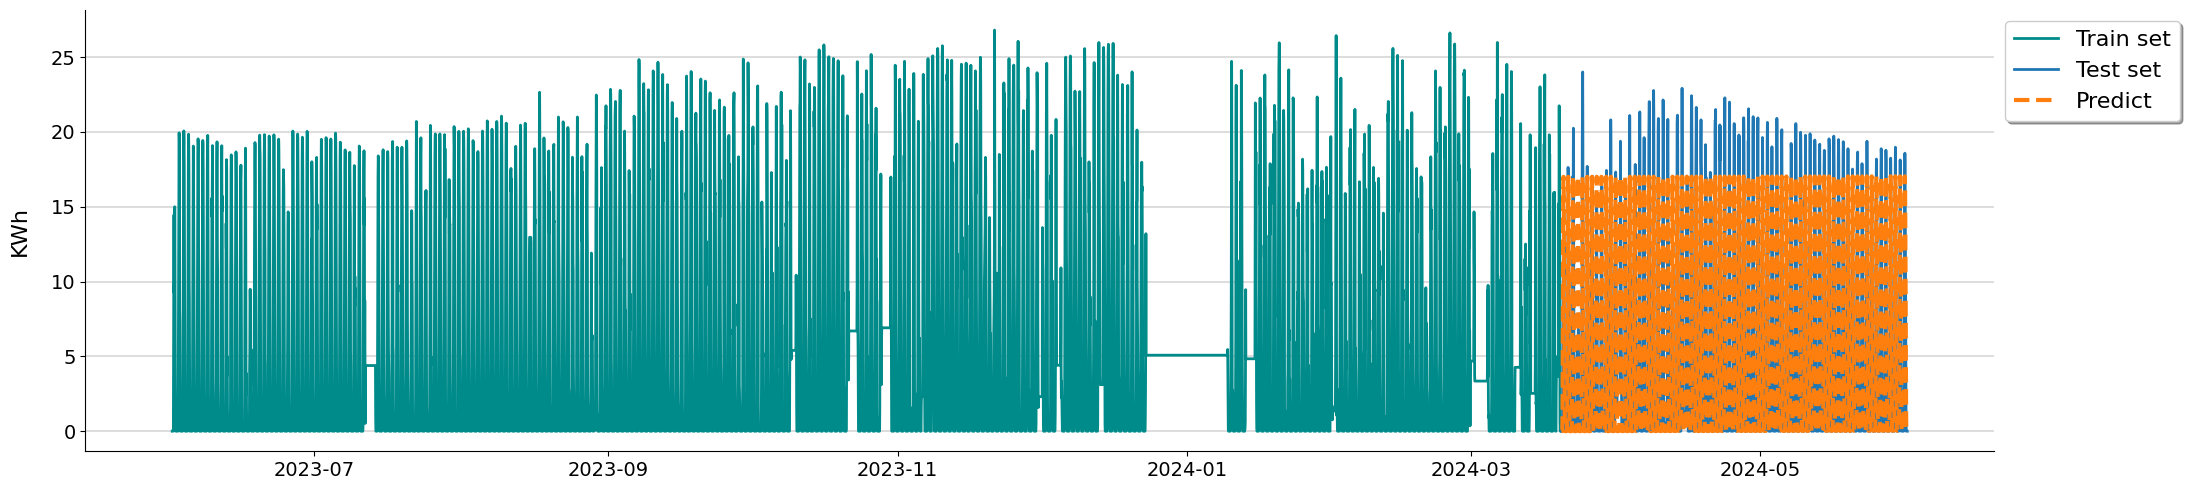

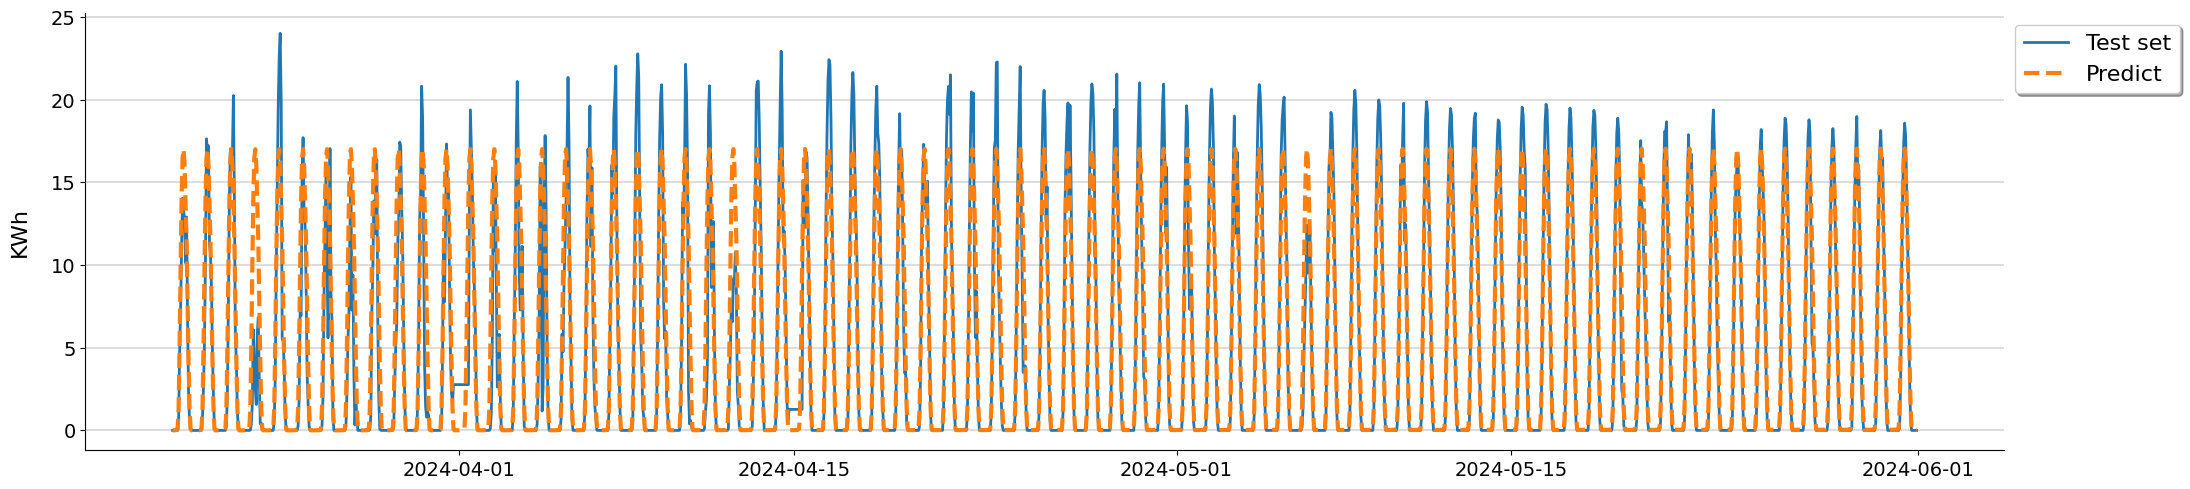

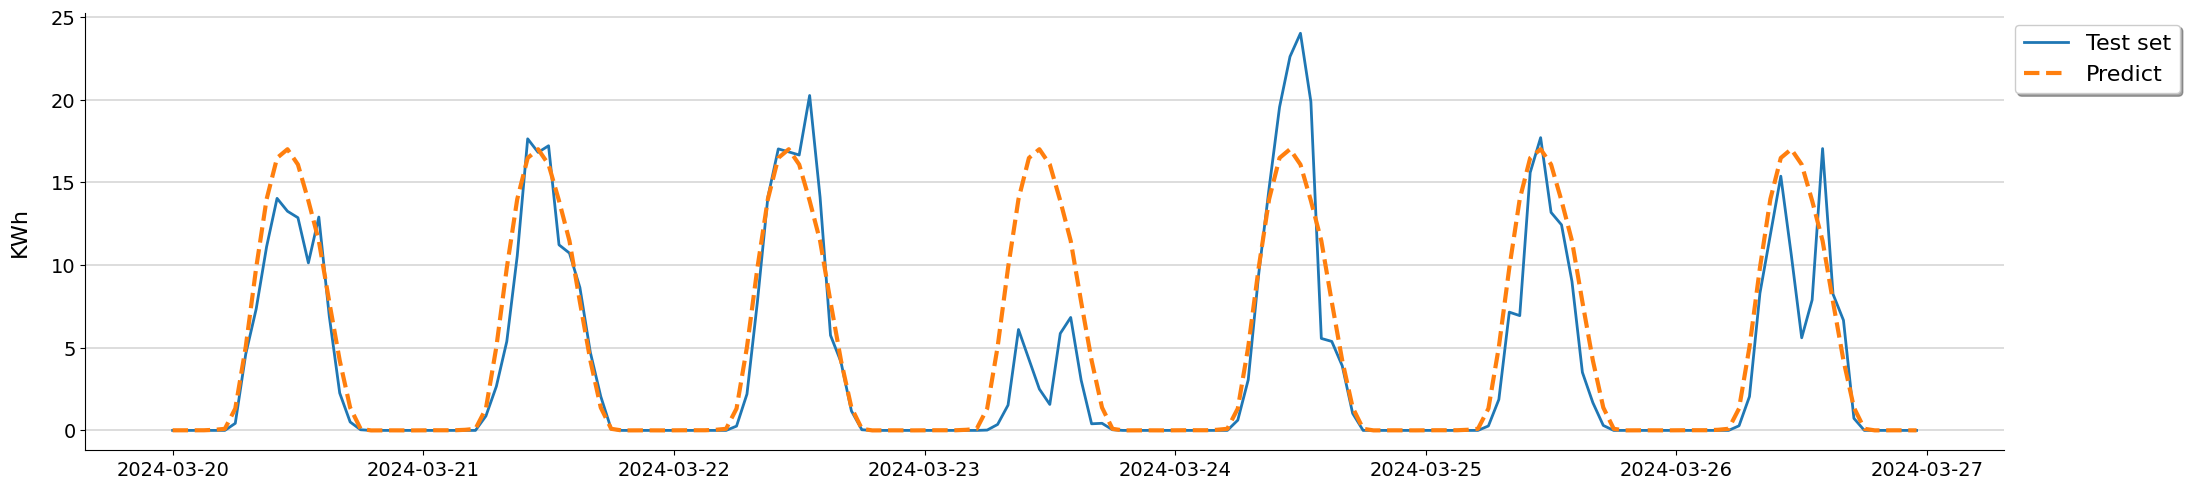

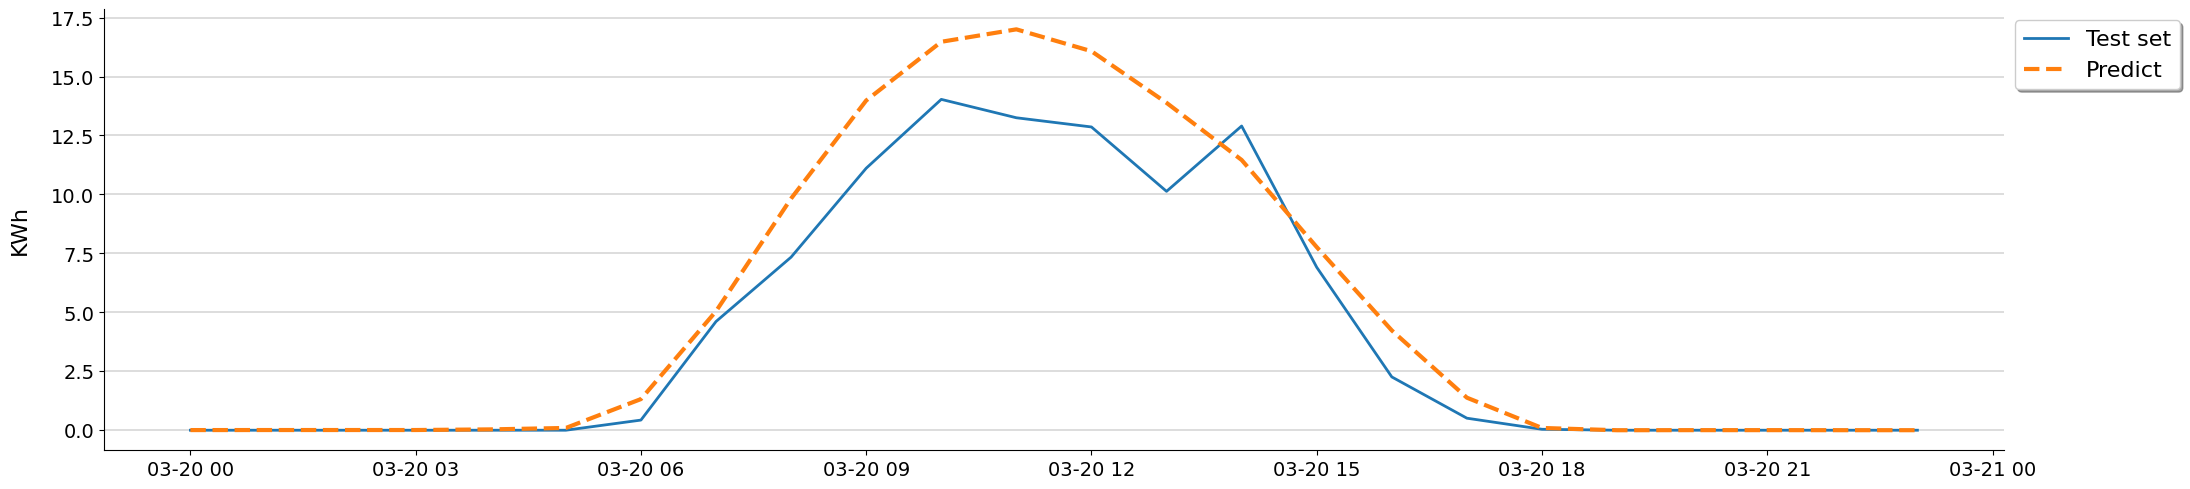

In [15]:

df_plot = pd.concat([df_train[TARGET], df_test[TARGET]], axis=1)
df_plot.columns = ["train", "test"]
df_plot = df_plot.join(df_pred, how="left")
df_plot.drop(columns=["y_true"], inplace=True)

df_plot.rename(columns={"y_pred_add": "y_pred"}, inplace=True)

plot_forecast(df_plot[["train", "test", "y_pred"]], "predict_full", span=False)
plot_forecast(df_plot[["test", "y_pred"]], "predict_test", span=False)

start = df_train.index.max() - pd.DateOffset(days=0)
end = start + pd.DateOffset(days=7)
plot_forecast(df_plot[["test", "y_pred"]], "predict_seven", start, end, span=False)

start = df_train.index.max() - pd.DateOffset(days=0)
end = start + pd.DateOffset(days=1)
plot_forecast(df_plot[["test", "y_pred"]], "predict_one", start, end, span=False)


------
##### Forecast TES 

In [16]:
# Treinar Modelo TES com todos os dados do data

small_value = 1e-1  # 0.0000000001
df_pos = df_base.replace(0, small_value)
df_pos.head()


ldtea_avg
date_time                           
2023-06-01 00:00:00-03:00        0.1
2023-06-01 01:00:00-03:00        0.1
2023-06-01 02:00:00-03:00        0.1
2023-06-01 03:00:00-03:00        0.1
2023-06-01 04:00:00-03:00        0.1

In [17]:
start_time_model = time.time()

tes_model_full = ExponentialSmoothing(
    df_base, 
    trend="add", 
    seasonal="add", 
    seasonal_periods=24
)

model_full_fit = tes_model_full.fit()

elapsed_time_full_set = time.time() - start_time_model
print(f"Tempo de treinamento: {elapsed_time_full_set:.2f} segundos")

Tempo de treinamento: 1.44 segundos


In [18]:
forecast_horizon = 24

y_pred = model_full_fit.forecast(forecast_horizon)
fc_pred = pd.DataFrame(y_pred, columns=["y_pred"])
y_eval = df_eval.loc[fc_pred.index]

print(df_pred.index.min(), df_pred.index.max())
display(df_pred.head(3))
print_forecast_accuracy(y_eval, fc_pred, df_base[TARGET], "TES - Eval Set (24h)")


2024-03-20 00:00:00-03:00 2024-05-31 23:00:00-03:00


y_true  y_pred_add  y_pred_mul  y_pred_sss_add  \
date_time                                                                   
2024-03-20 00:00:00-03:00     0.0    0.005895    0.113144    1.265553e+17   
2024-03-20 01:00:00-03:00     0.0    0.007771    0.122755    2.153530e+17   
2024-03-20 02:00:00-03:00     0.0    0.008149    0.135871    3.158270e+17   

                           y_pred_sss_mul  
date_time                                  
2024-03-20 00:00:00-03:00       36.427288  
2024-03-20 01:00:00-03:00       34.153062  
2024-03-20 02:00:00-03:00       34.004532

                       Resumo das métricas de precisão (forecast accuracy - TES - Eval Set (24h))                       
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | ( 0.84 -  1.53) | As previsões, em média, estão (0.84 - 1.53) unidades distantes dos valores reais.
RMSE    | ( 1.48 -  2.01) | O erro médio do seu modelo é de (1.48 - 2.01) unidades em relação aos valores observados.
R²      | ( 0.94 -  0.89) | O coeficiente de determinação R² é (93.96% - 93.96%).
MSE     | ( 2.18 -  4.02) | A média dos quadrados das diferenças entre os valores previstos e reais é (2.18 - 2.18)
MAPE    | ( 0.46 -  0.46) | As previsões, em média, estão desviando em (46.22% - 46.22%) dos valores reais.
MASE    | ( 0.83 -  0.81

In [19]:
# Salvar metricas em arquivo .csv

metrics = calculate_forecast_accuracy(y_eval, fc_pred, df_base[TARGET],)
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
metrics = {k: round(v, 3) for k, v in metrics.items()}

metadata={
    "time": round(elapsed_time_full_set, 4), 
    "dataset": "eval24", 
    "features" : "st=add_s24",
    "date_exp": now
}
save_score_metrics(metrics, "tes", metadata=metadata)


Métricas salvas com sucesso em: /home/vieira/unb/tcc/repos/sige-ai/data/results/estatical_models/tes.csv


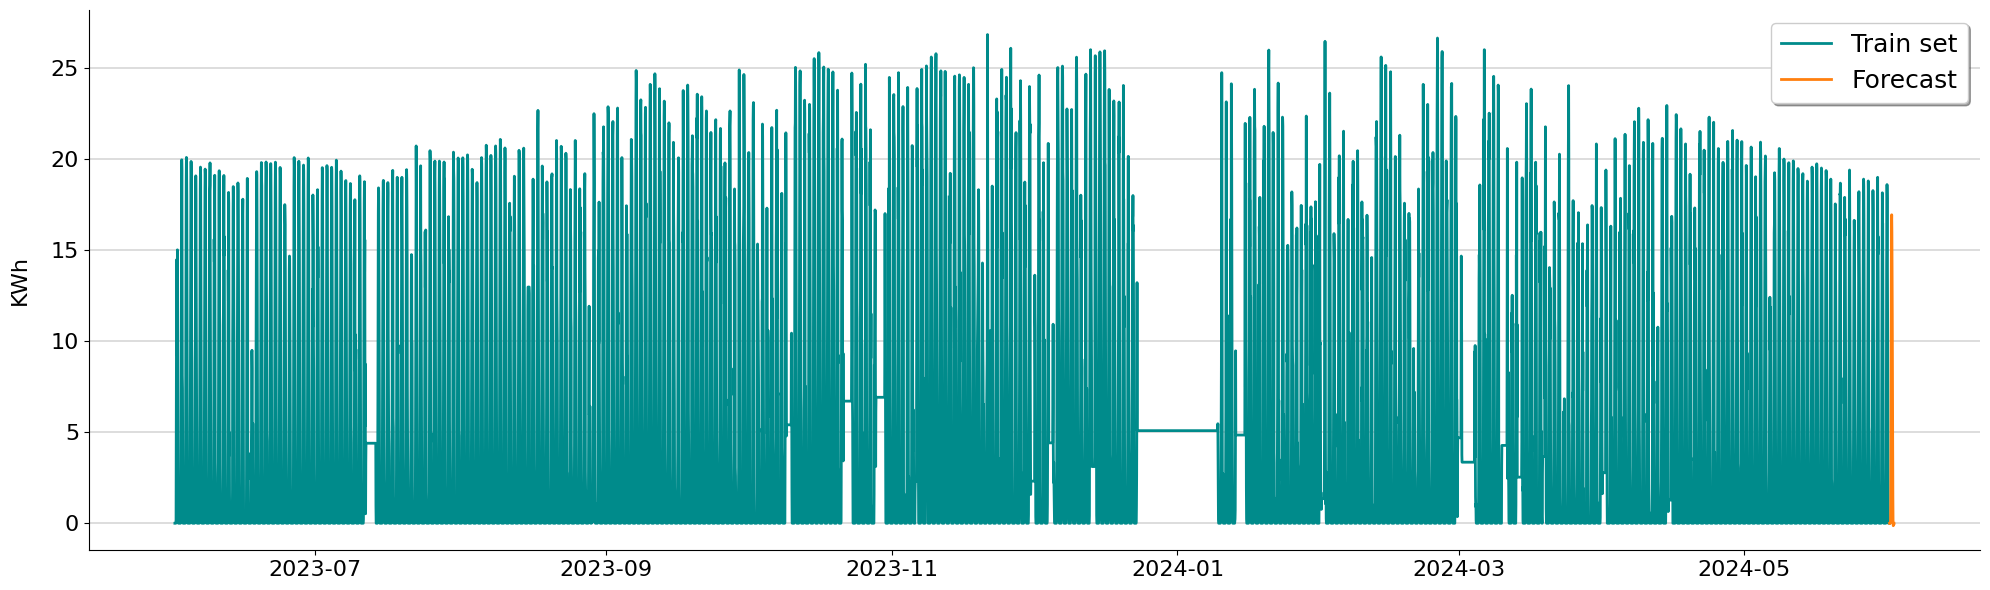

In [20]:
plt.figure(figsize=(20, 6))

plt.plot(df_base.index, df_base, label="Train set", color=color_train, lw=2)
plt.plot(fc_pred.index, fc_pred, label="Forecast", color=color_future, lw=2)

# plt.title("LDTEA - TES ADD Forecast 24 steps", fontsize=20, fontweight="bold", pad=20)
plt.ylabel("KWh", fontsize=16, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)

plt.legend(
    fontsize=18,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
if SAVE_PLOT:
    plt.savefig("../figures/tes/forecast_full_24h.pdf", dpi=300)
    plt.savefig("../figures/tes/forecast_full_24h.svg", dpi=300)
plt.show()



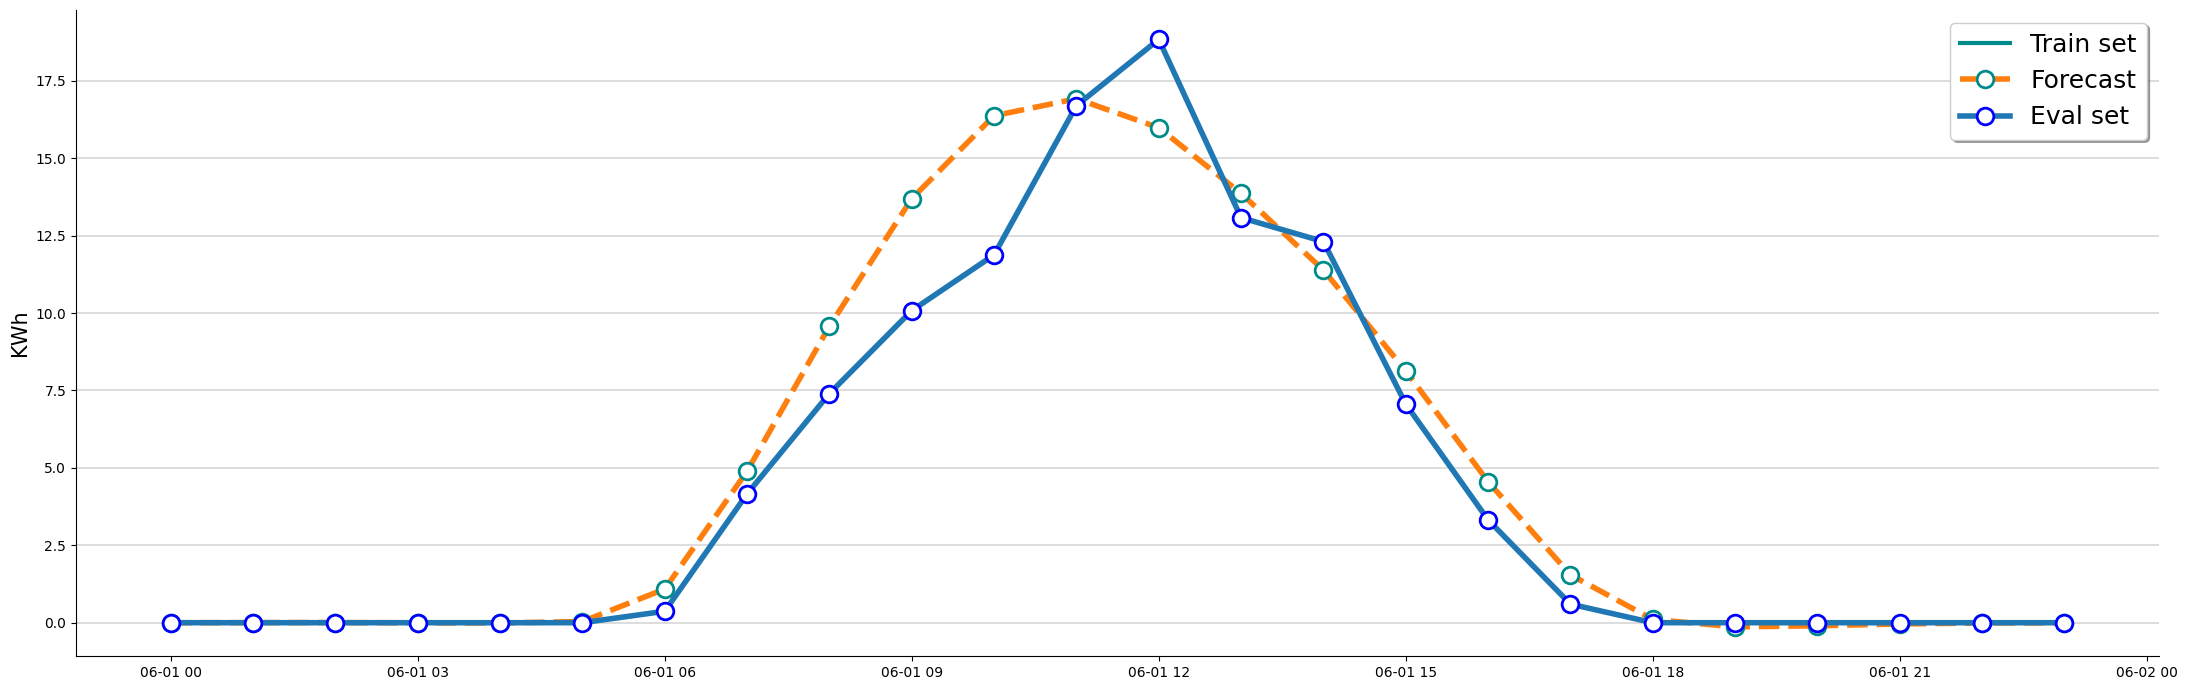

In [21]:
index_min = df_base.index.max()
df_lm = df_base[df_base.index > index_min]

plt.figure(figsize=(22, 7))

plt.plot(
    df_lm.index,
    df_lm,
    label="Train set",
    color=color_train,
    lw=3,
)

plt.plot(
    fc_pred.index,
    fc_pred,
    label="Forecast",
    color=color_future,
    marker="o",
    ls="--",
    lw=4,
    markersize=12,
    markerfacecolor="white",
    markeredgewidth=2,
    markeredgecolor=dark_cyan,
)

plt.plot(
    y_eval.index,
    y_eval,
    label="Eval set",
    color=color_test,
    marker="o",
    lw=4,
    markersize=12,
    markerfacecolor="white",
    markeredgecolor="blue",
    markeredgewidth=2,
)

# plt.title("LDTEA - ETS Forecast 24 steps", fontsize=18)
plt.ylabel("KWh", fontsize=15)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.legend(
    fontsize=18,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
if SAVE_PLOT:
    plt.savefig("../figures/tes/forecast_od.pdf", dpi=300)
    plt.savefig("../figures/tes/forecast_od.svg", dpi=300)
plt.tight_layout()
plt.show()


In [22]:
forecast_horizon = len(df_eval)

y_pred = model_full_fit.forecast(forecast_horizon)
fc_pred = pd.DataFrame(y_pred, columns=["y_pred"])
y_eval = df_eval.loc[fc_pred.index]

print(df_pred.index.min(), df_pred.index.max())
display(df_pred.head(3))
print_forecast_accuracy(y_eval, fc_pred, df_base[TARGET], f"TES - Eval Set ({len(df_eval)})")

2024-03-20 00:00:00-03:00 2024-05-31 23:00:00-03:00


y_true  y_pred_add  y_pred_mul  y_pred_sss_add  \
date_time                                                                   
2024-03-20 00:00:00-03:00     0.0    0.005895    0.113144    1.265553e+17   
2024-03-20 01:00:00-03:00     0.0    0.007771    0.122755    2.153530e+17   
2024-03-20 02:00:00-03:00     0.0    0.008149    0.135871    3.158270e+17   

                           y_pred_sss_mul  
date_time                                  
2024-03-20 00:00:00-03:00       36.427288  
2024-03-20 01:00:00-03:00       34.153062  
2024-03-20 02:00:00-03:00       34.004532

                       Resumo das métricas de precisão (forecast accuracy - TES - Eval Set (720))                       
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | ( 1.12 -  1.61) | As previsões, em média, estão (1.12 - 1.61) unidades distantes dos valores reais.
RMSE    | ( 2.21 -  2.72) | O erro médio do seu modelo é de (2.21 - 2.72) unidades em relação aos valores observados.
R²      | ( 0.86 -  0.81) | O coeficiente de determinação R² é (86.50% - 86.50%).
MSE     | ( 4.88 -  7.40) | A média dos quadrados das diferenças entre os valores previstos e reais é (4.88 - 4.88)
MAPE    | ( 0.70 -  0.67) | As previsões, em média, estão desviando em (70.34% - 70.34%) dos valores reais.
MASE    | ( 0.89 -  0.82

In [23]:
# Salvar métricas em arquivo .csv

metrics = calculate_forecast_accuracy(y_eval, fc_pred, df_base[TARGET])
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
metrics = {k: round(v, 3) for k, v in metrics.items()}

metadata={
    "time": round(elapsed_time_full_set, 4), 
    "dataset": "eval168", 
    "features" : "st=add_s24",
    "date_exp": now
}
save_score_metrics(metrics, "tes", metadata=metadata)


Métricas salvas com sucesso em: /home/vieira/unb/tcc/repos/sige-ai/data/results/estatical_models/tes.csv


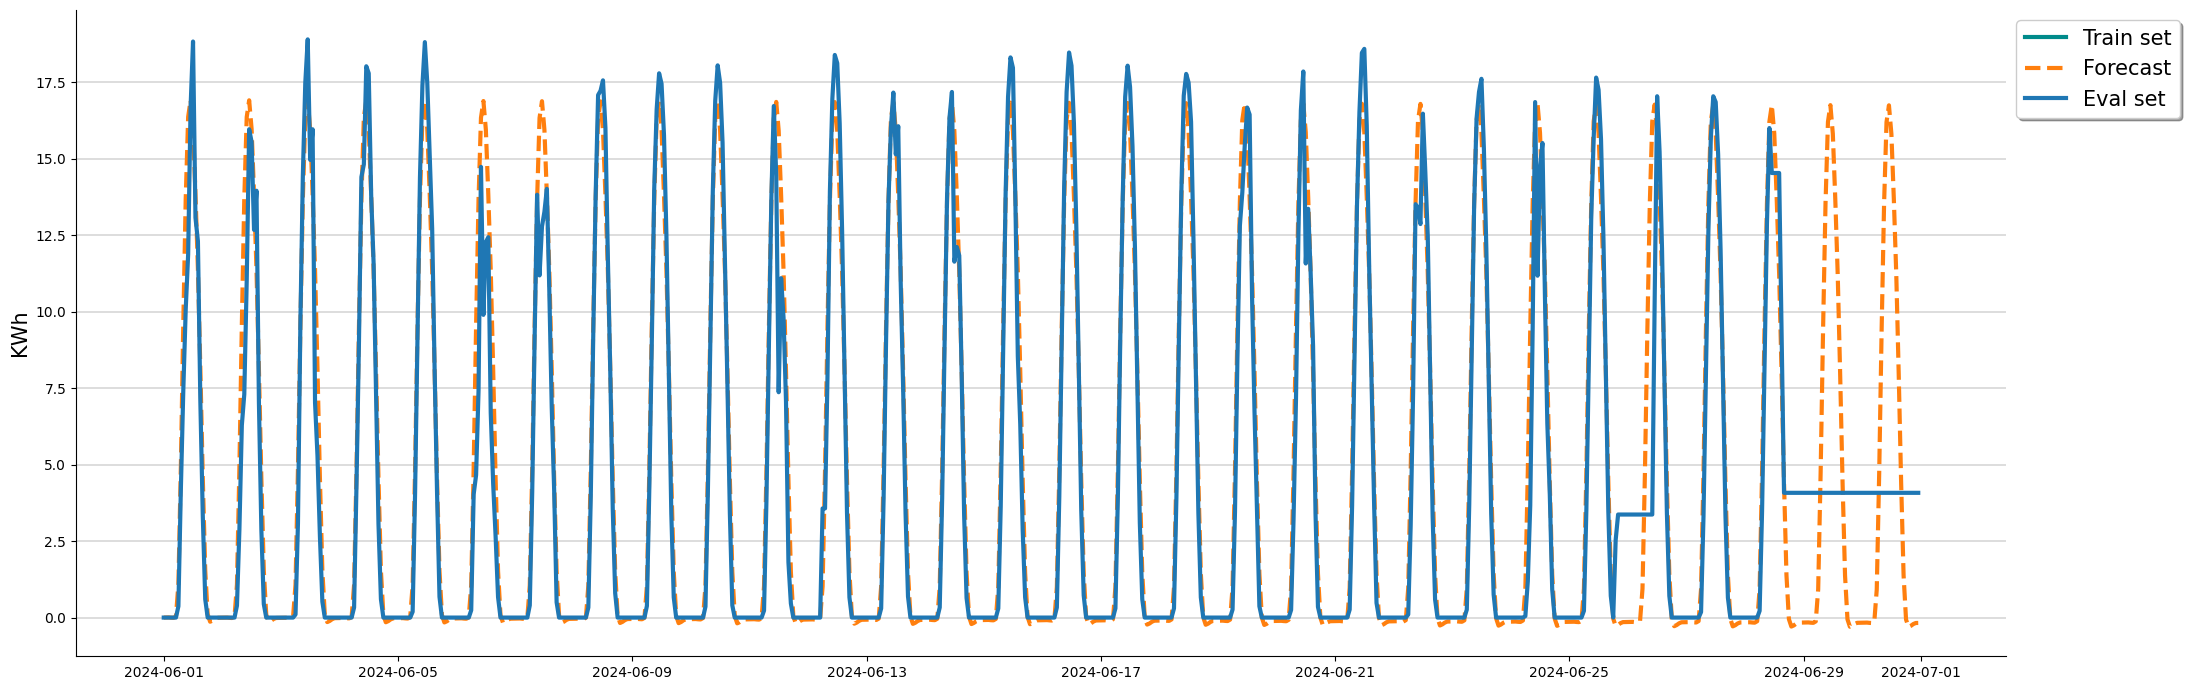

In [24]:
index_min = df_base.index.max()
df_lm = df_base[df_base.index > index_min]

plt.figure(figsize=(22, 7))

plt.plot(
    df_lm.index,
    df_lm,
    label="Train set",
    color=color_train,
    lw=3,
)

plt.plot(
    fc_pred.index,
    fc_pred,
    label="Forecast",
    color=color_future,
    lw=3,
    linestyle="--",
)

plt.plot(
    y_eval.index,
    y_eval,
    label="Eval set",
    color=color_test,
    lw=3,
)

# plt.title("LDTEA - ARIMA Forecast 144 steps", fontsize=18)
plt.ylabel("KWh", fontsize=15)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
if SAVE_PLOT:
    plt.savefig("../figures/tes/tes_fc_eval_sd.pdf", dpi=300)
    plt.savefig("../figures/tes/tes_fc_eval_sd.svg", dpi=300)
plt.tight_layout()
plt.show()

In [25]:
# salvar modelo treinado com conjunto completo de dados

save_model(model_full_fit, "tes_add")


Modelo tes_add salvo em /home/vieira/unb/tcc/repos/sige-ai/models
